# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


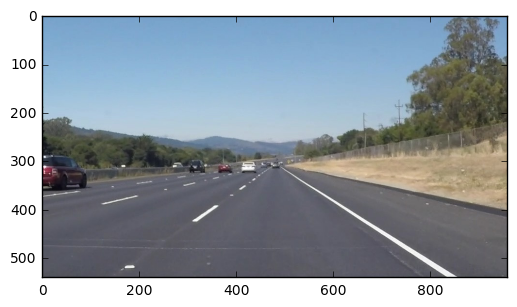

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'XsolidYellowLeft.jpg',
 'XwhiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'XsolidYellowCurve2.jpg',
 'XsolidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'XsolidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'XsolidWhiteCurve.jpg']

### My notes:

All the images are the same size.  If not we would have need to define region of interest in relative rather than absolute coordinates.  In a real car we would have control over the images but for testing that is not necessarily A case. 

Now let's build the pipeline - for now the parameters we apply to a video stream are fixed.  So I am going to encode them as default values in the pipeline function.   This first pipeline just generates the Hough lines.  It took about 5 minutes to find good settings here.  

Would be good to display images in a more interactive mode - so reading off coordinates is easier.  Maybe try and explore what is possible with Bokeh.

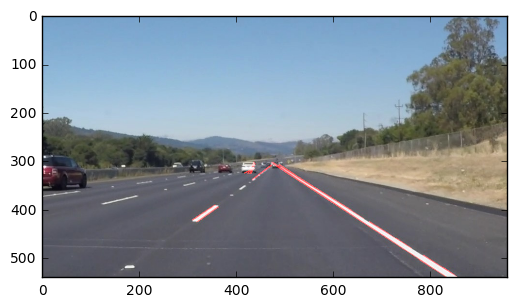

In [5]:
def line_pipeline(img, 
                  kernel_size = 7, 
                  low_threshold = 50, 
                  high_threshold = 150,
                  region = [[(440,300),(500, 300),(880, 539),(80,539)]],
                  rho = 2,
                  theta = np.pi/180,
                  threshold = 3,
                  min_line_len = 20,
                  max_line_gap = 10,
                  α=0.8, 
                  β=1.0, 
                  λ=0.0):
    base = mpimg.imread(img)
    image = grayscale(base)
    image = gaussian_blur(image, kernel_size)
    image = canny(image, low_threshold, high_threshold)
    image = region_of_interest(image, np.array(region, dtype=np.int32))
    image = hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap)
    image = weighted_img(base, image, α, β, λ)
    return(image)
    

def transform_all(dir):
    for f in os.listdir(dir):
        if not f.startswith("X") and f.endswith(".jpg"):
            image = line_pipeline(dir+f)
            fname = ''.join([dir,'X',f])
            cv2.imwrite(fname,cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        

transform_all('test_images/')

image = mpimg.imread('test_images/XsolidWhiteRight.jpg')
plt.imshow(image)

Looks good - now we are going to work on the averaging of the lines.  Initially I will keep it really simple and just average the gradients and intercepts of the postive and negative hough lines.  I suspect this is too simple - but let's see:

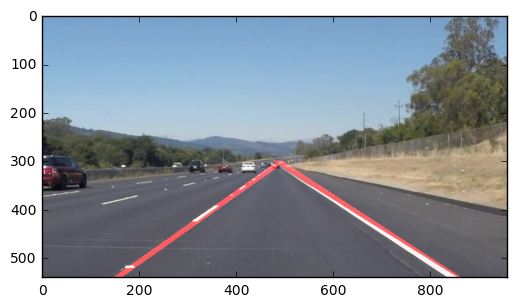

In [6]:
import pdb;

def line_segment(x1, x2, m, b):
        y1 = m * x1 + b
        y2 = m * x2 + b
        return (np.array([[x1, y1, x2, y2]], dtype = np.int32))
    
    
def average_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    # From the list of Hough lines, return no more than two dominant positive / negative gradient lines
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # We will store positive and negative m,b values
    p = np.empty((0,2))
    n = np.empty((0,2))
    
    for line in lines:
        x1 = line[0,0]
        y1 = line[0,1]
        x2 = line[0,2]
        y2 = line[0,3]
        m = ((y2-y1)/(x2-x1))
        b = (y1 -( m * x1))
        if m > 0:
            p = np.vstack(( np.array((m,b), dtype=np.float32) , p ))
        else:
            n = np.vstack(( np.array((m,b), dtype=np.float32) , n ))
    
    
    l = np.empty((0,4), dtype=np.int32)
    
    # Compute summary metrics for postive and negative if segments found
    
    if (p.size > 0):
        mb = np.median(p, 0)
        l = np.vstack((line_segment(480, 960, mb[0], mb[1]), l))
        
    if (n.size > 0):
        mb = np.median(n, 0)
        l = np.vstack((line_segment(0, 480, mb[0], mb[1]), l))
     
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, [l], thickness=10)    
    return line_img

def ave_line_pipeline(image, 
                  kernel_size = 7, 
                  low_threshold = 50, 
                  high_threshold = 150,
                  region = [[(440,300),(500, 300),(880, 539),(80,539)]],
                  rho = 2,
                  theta = np.pi/180,
                  threshold = 3,
                  min_line_len = 20,
                  max_line_gap = 10,
                  α=0.8, 
                  β=1.0, 
                  λ=0.0):
    base = image
    image = grayscale(base)
    image = gaussian_blur(image, kernel_size)
    image = canny(image, low_threshold, high_threshold)
    image = region_of_interest(image, np.array(region, dtype=np.int32))
    image = average_lines(image, rho, theta, threshold, min_line_len, max_line_gap)
    image = region_of_interest(image, np.array(region, dtype=np.int32))
    image = weighted_img(base, image, α, β, λ)
    return(image)


def transform_all(dir):
    for f in os.listdir(dir):
        if not f.startswith("X") and f.endswith(".jpg"):
            image = ave_line_pipeline(mpimg.imread(dir+f))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            fname = ''.join([dir,'X',f])
            cv2.imwrite(fname,image)
        

transform_all('test_images/')

image = mpimg.imread('test_images/XsolidWhiteRight.jpg')
plt.imshow(image)


Switched to median - simple averaging gets knocked off by outlying points in m,b space.  Median is be better.  We could also do a simple clustering - identify points clustered tightly in m,b space.  For now though I am going to stick with averaging and make sure video works.  We can always refine this later on.

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

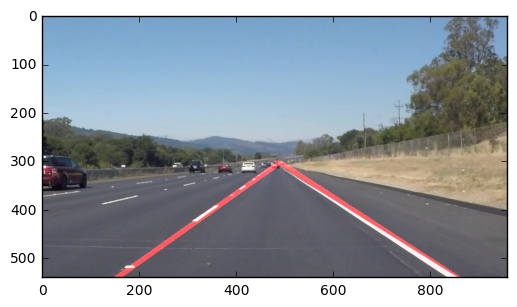

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = ave_line_pipeline(image)
    return result


plt.imshow(process_image(mpimg.imread('test_images/solidWhiteRight.jpg')))

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:12<00:00, 15.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1.66 s, sys: 132 ms, total: 1.8 s
Wall time: 14.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


 10%|█         | 69/682 [00:03<00:49, 12.49it/s]

In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Thoughts:

* At first I was thinking that the need to define the region of interest was a limiting factor in this approach.  Somehow it felt like cheating - since this is a strong prior assumption we are making about the position of the lines.  However on reflection for a certain type of road (Highway 280 in CA) it seems like a sensible first approach and for roads like this with clear makrings provides one good source of information.  
* Before we started averaging the lines in (m, b) space I was wondering if we needed to have a more adaptive gaussian filter - that has a bigger kernel width higher up the image.  I could see detailed little lines around cars and details that I did not want to pick up.  I sort of wished my vision was not so crisp out in the middle of the y-axis and above.  It might be a way to reduce the sensitivity of the approach to the region of interest.  However on reflection  distant objects are already smaller relative to the gaussian filter so this is already happening to a degree.  Also once we clustered the lines in (m, b) space to find the dominant positive and negative gradient line this problem was resolved.
* I would like to test this on more videos - specifically bigger corners / curves.  I also wonder what would happen if the car was travelling uphill and downhill rather than on a gentle gradient.  I do not expect the algorithm would do very well in a more built up area with more edges in the region of interest.  Also if strong shadows fall across the road they could dominate.  Sometimes also there are lines in the surface of the road that cross the actual lanes.  These algorithms could easily be fooled by such information.  Also in bad weather and dark conditions it would fail completely (unless we had higher frequency IR sensors and special paint).
* The region of interest would be a calibration that would be required for a specific car / camera combo.  It would be great to not have to bake in such a hard wired decision.  Maybe it could be dynamically defined - for example if we find no lines expand it out - if too many lines bring to centre.
* When configuring the various parameter for the pipeline I felt it took too long. There are too many parameters to efficiently optimise by hand.  I would like to research if there is a way to automate this search.  For example some form of grid search over a number of images.  Not sure what the objective function would be?  Maybe score highly if result has topology we are looking for - need to research ways of defining goodness for this region of interest.
* I recognise these roads!  I hope we build self driving cars that work on any road on the planet.  Algorithms will need tuning globally - and what if in winter / wet you cannot see the lines.  Maybe we need to rethink the way we build and paint roads for self driving cars.  I am sure we could make them easier for sensors to grok.  
* I never realised variables in python could be Greek letters - cool!
* I had not done any video/image processing like this before - it was a lot of fun - I would like to research the Hough transformation some more - I feel my understanding is practical enough to allow me to use it - but I would have liked to have a deeper understanding about it and the OpenCCV libraries - for example I do not think I had to necessarily work with Hough lines in (x,y) space - it would have been easier to stay in (m, b) space.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [63]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:31<00:00,  8.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 3.42 s, sys: 240 ms, total: 3.66 s
Wall time: 34.1 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))